## 特征构建
1. 检查数据集；
2. 填充分类特征；
3. 编码分类变量；
4. 扩展数值特征；
5. 针对文本的特征构建。

### 4.1 检查数据集

In [ ]:
# 导入Pandas
import pandas as pd

In [ ]:
X = pd.DataFrame({
    'city': ['tokyo', None, 'london', 'seattle', 'san francisco', 'tokyo'],
    'boolean': ['yes', 'no', None, 'no', 'no', 'yes'],
    'ordinal_column': ['somewhat like', 'like', 'somewhat like', 'like', 'somewhat like', 'dislike'],
    'quantitative_column': [1, 11, -.5, 10, None, 20]
})

In [ ]:
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


1. boolean（布尔值）：此列是二元分类数据（是/否），定类等级；
2. city（城市）：此列是分类数据，也是定类等级；
3. ordinal_column（顺序列）：此列是顺序数据，定序等级；
4. quantitative_column（定量列）：此列是整数，定比等级（是否存在绝对零点）。

In [ ]:
# 查看缺失值
X.isnull().sum()

city                   1
boolean                1
ordinal_column         0
quantitative_column    1
dtype: int64

In [ ]:
# 对于数值型数据，可以通过计算均值的方法填充缺失值；对于分类数据，计算最常见的类來填充。
# 寻找city列中最常见的元素
X['city'].value_counts().index[0]  #value_counts 方法。这样会返回一个对象，由高到低。包含列中的各个元素——第一个元素就是最常出现的。

'tokyo'

In [ ]:
# 用最常见的值填充city列
X['city'].fillna(X['city'].value_counts().index[0])

0            tokyo
1            tokyo
2           london
3          seattle
4    san francisco
5            tokyo
Name: city, dtype: object

## 4.2 填充分类特征
### 4.2.1 自定义填充器
流水线的中间步骤只能是转换，意味着必须实现fit和transform方法。  
流水线的目的是将几个可以交叉验证的步骤组装在一起，并设置不同的参数。  
下面开始编写自定义分类填充器：

### 4.2.2 自定义分类填充器

In [ ]:
from sklearn.base import TransformerMixin

In [ ]:
class CustomCategoryImputer(TransformerMixin):
    def __init__(self, cols=None):  #我们已经对这个自定义类进行了实例化，并用__init__方法对属性进行了初始化。
        self.cols = cols #在这里，只需要初始化一个实例属性self.cols（就是我们指定为参数的列）
        
    def transform(self, df): 
        X = df.copy()  #首先将这个DataFrame 复制一份，命名为X
        for col in self.cols:  #遍历cols 参数指定的列，填充缺失值。
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
            
    # 不需要fit什么东西，直接返回fit self
    def fit(self, *_):
        return self

In [ ]:
# 在列上应用自定义分类填充器：
cci = CustomCategoryImputer(cols=['city', 'boolean'])

In [ ]:
# 我们初始化了一个自定义分类填充器，现在需要在数据集上调用fit_transform 函数：
cci.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


#### 4.2.3 自定义定量填充器
定量列还有缺失值，我们再来自定义一个

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
        
    def transform(self, df):
        X = df.copy()
        impute = SimpleImputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
            
    # 不需要fit什么东西，直接返回fit self
    def fit(self, *_):
        return self

In [ ]:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'], strategy='mean')

In [ ]:
cqi.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


In [ ]:
# 可以不使用fit_transform拟合转换，而是把它们放在流水线中
# 从sklearn导入Pipeline
from sklearn.pipeline import Pipeline

In [ ]:
# 导入自定义填充器
imputer = Pipeline([('quant', cqi), ('category', cci)])
imputer.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


## 4.3 编码分类变量
任何机器学习算法，需要的输入特征都必须是数值，有几种办法可以将分类数据转换为数值数据：

#### 4.3.1 定类等级的编码
定类等级编码的主要方法是将分类数据转换为虚拟变量（dummy variable），有两种方法：
1. 用Pandas自动找到分类变量并进行编码；
2. 创建自定义虚拟变量编码器，在流水线工作。

In [ ]:
# 1. 用Pandas自动找到分类变量并进行编码
pd.get_dummies(X, columns=['city', 'boolean'], prefix_sep='__')  # prefix_sep前缀（列名）和单元格值之间的分隔符

,ordinal_column,quantitative_column,city__london,city__san francisco,city__seattle,city__tokyo,boolean__no,boolean__yes
0,somewhat like,1.0,0,0,0,1,0,1
1,like,11.0,0,0,0,0,1,0
2,somewhat like,-0.5,1,0,0,0,0,0
3,like,10.0,0,0,1,0,1,0
4,somewhat like,NaN,0,1,0,0,1,0
5,dislike,20.0,0,0,0,1,0,1


In [ ]:
# 2. 创建自定义虚拟变量编码器
class CustomDummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cols)
    
    def fit(self, *_):
        return self

In [ ]:
cd = CustomDummifier(cols=['boolean', 'city'])

In [ ]:
cd.fit_transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,somewhat like,1.0,0,1,0,0,0,1
1,like,11.0,1,0,0,0,0,0
2,somewhat like,-0.5,0,0,1,0,0,0
3,like,10.0,1,0,0,0,1,0
4,somewhat like,NaN,1,0,0,1,0,0
5,dislike,20.0,0,1,0,0,0,1


#### 4.3.2 定序等级的编码
定序等级，由于数据的顺序有意义，使用虚拟变量是没有意义的。为了保持顺序，我们使用**标签编码器**。  
**标签编码器**是指，顺序数据的每个标签都会有一个相关的值。在我们的例子中，这意味着顺序列的值（dislike, somewhat like, like）用（0, 1, 2）表示。

In [ ]:
# 创建一个列表，顺序数据对应于列表索引
ordering = ['dislike', 'somewhat like', 'like']  #0 是dislike，1 是somewhat like，2是like

In [ ]:
# 在将ordering 映射到顺序列之前，先看一下列
print(X['ordinal_column'])

0    somewhat like
1             like
2    somewhat like
3             like
4    somewhat like
5          dislike
Name: ordinal_column, dtype: object


In [ ]:
# 将ordering映射到顺序列
X['ordinal_column'].map(lambda x: ordering.index(x))

0    1
1    2
2    1
3    2
4    1
5    0
Name: ordinal_column, dtype: int64

注意，我们没有使用scikit-learn 的LabelEncoder，因为这个方法不能像上面的代码那样对顺序进行编码（0 表示dislike，1 表示somewhat like，2 表示like）。它默认是一个排序方法，而我们不想这么做。

In [ ]:
# 还是将自定义标签编码器放进流水线：
class CustomEncoder(TransformerMixin):
    def __init__(self, col, ordering=None):
        self.ordering = ordering
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda x: self.ordering.index(x))
        return X
    
    def fit(self, *_):
        return self

In [ ]:
ce = CustomEncoder(col='ordinal_column', ordering=['dislike', 'somewhat like', 'like'])  #关键参数是ordering，它会指定将标签编码成什么数值。
ce.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,1,1.0
1,None,no,2,11.0
2,london,None,1,-0.5
3,seattle,no,2,10.0
4,san francisco,no,1,NaN
5,tokyo,yes,0,20.0


#### 4.3.3 将连续特征分箱
有时，如果数值数据是连续的，那么将其转换为分类变量可能是有意义的。例如你的手上有
年龄，但是年龄段可能会更有用。

Pandas 有一个有用的函数叫作cut，可以将数据分箱（binning），亦称为分桶（bucketing）。意思就是，它会创建数据的范围。

In [ ]:
# 默认的类别名就是分箱
pd.cut(X['quantitative_column'], bins=3)

0     (-0.52, 6.333]
1    (6.333, 13.167]
2     (-0.52, 6.333]
3    (6.333, 13.167]
4                NaN
5     (13.167, 20.0]
Name: quantitative_column, dtype: category
Categories (3, interval[float64]): [(-0.52, 6.333] < (6.333, 13.167] < (13.167, 20.0]]

当指定的bins为整数的时候（bins=3），会定义X范围内的等宽分箱数。并且两边的氛围分别扩展了0.1%，已包括最小值和最大值。  
可以将标签设置为False，这将返回分箱的整数指示器：

In [ ]:
# 不使用标签
pd.cut(X['quantitative_column'], bins=3, labels=False)

0    0.0
1    1.0
2    0.0
3    1.0
4    NaN
5    2.0
Name: quantitative_column, dtype: float64

In [ ]:
# 自定义转换器流水线
class CustomCutter(TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.col = col
        self.bins = bins
        self.labels = labels
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X
    
    def fit(self, *_):
        return self

In [ ]:
cc = CustomCutter(col='quantitative_column', bins=3, labels=False)
cc.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,0.0
1,None,no,like,1.0
2,london,None,somewhat like,0.0
3,seattle,no,like,1.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,2.0


注意：quantitative_column属于定序等级，不需要引入虚拟变量。

In [ ]:
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


#### 4.3.4 创建流水线
1. boolean和city：虚拟变量编码；
2. ordinal_column：标签编码；
3. quantitative_column：分箱。

**组装流水线：**

In [ ]:
from sklearn.pipeline import Pipeline

**流水线顺序**：
1. 用imputer填充缺失值；
2. 用虚拟变量填充分类列；
3. 对ordinal_column进行编码；
4. 将quantitative_column分箱。

In [ ]:
pipe = Pipeline([("imputer", imputer), ("dummify", cd), ('encode', ce), ('cut', cc)])
# 先是imputer
# 然后是虚拟变量
# 接着编码顺序列
# 最后分箱定量列

In [ ]:
# 进入流水线前的数据
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


In [ ]:
# 拟合流水线
pipe.fit(X)

Pipeline(memory=None,
         steps=[('imputer',
                 Pipeline(memory=None,
                          steps=[('quant',
                                  <__main__.CustomQuantitativeImputer object at 0x7f9b15d7d978>),
                                 ('category',
                                  <__main__.CustomCategoryImputer object at 0x7f9b191ee2e8>)],
                          verbose=False)),
                ('dummify',
                 <__main__.CustomDummifier object at 0x7f9b15d95b38>),
                ('encode', <__main__.CustomEncoder object at 0x7f9b15b2e9e8>),
                ('cut', <__main__.CustomCutter object at 0x7f9b158b6c50>)],
         verbose=False)

In [ ]:
#创建流水线对象后，可以转换DataFrame：
pipe.transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,1,0,0,1,0,0,0,1
1,2,1,1,0,0,0,0,1
2,1,0,1,0,1,0,0,0
3,2,1,1,0,0,0,1,0
4,1,1,1,0,0,1,0,0
5,0,2,0,1,0,0,0,1


## 4.4 扩展数值特征
有多种办法可以从数值特征中创建扩展特征。在深入研究前，先介绍一个新的数据集。
### 4.4.1 根据胸部加速度计识别动作的数据集
数据集包含：
- 序号
- x轴加速度
- y轴加速度
- z轴加速度
- 标签

标签是数字，每个数字代表一种动作。

In [ ]:
# 加载csv文件，并设置每列标题：
# 如果没有 header=None，第一行数据会被覆盖掉
df = pd.read_csv('1.csv', header=None)
df.columns = ['index', 'x', 'y', 'z', 'activity']

In [ ]:
df.head()

,index,x,y,z,activity
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


In [ ]:
# 我们的目标是预测activity列，首先要确定要击败的空准确率。
df['activity'].value_counts(normalize=True)

7    0.515369
1    0.207242
4    0.165291
3    0.068793
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: activity, dtype: float64

空准确率是51.54%，意味着如果我们猜7（站立着讲话），正确率就超过一半了。现在开始
进行机器学习，一步步建立模型。

In [ ]:
# 建立模型
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X = df[['x', 'y', 'z']]
y = df['activity']

# 网格搜索所需的变量和实例

# 需要试验的KNN模型参数
knn_params = {'n_neighbors': [3, 4, 5, 6]}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7408140649873495 {'n_neighbors': 5}


使用5 个邻居作为参数时，KNN 模型准确率达到了72.08%，比51.54%的空准确率高得多。
也许还有别的办法可以进一步提高准确率。

In [ ]:
X.isnull().sum()

x    0
y    0
z    0
dtype: int64

### 4.4.2 多项式特征
在处理数值数据、创建更多特征时，一个关键方法是使用scikit-learn 的Polynomial-
Features 类。这个构造函数会创建新的列，它们是原有列的乘积，用于捕获特征交互。

更具体地说，这个类会生成一个新的特征矩阵，里面是原始数据各个特征的多项式组合，阶
数小于或等于指定的阶数。意思是，如果输入是二维的，例如[a, b]，那么二阶的多项式特征就是[1, a, b, a^2, ab, b^2]。

In [ ]:
X.shape

(162501, 3)

In [ ]:
X.head()

,x,y,z
0,1502,2215,2153
1,1667,2072,2047
2,1611,1957,1906
3,1601,1939,1831
4,1643,1965,1879


In [ ]:
# 导入多项式特征类，并设置参数来实例化
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
# degree 是多项式特征的阶数，默认值是2。
# interaction_only 是布尔值：如果为真，表示只生成互相影响/交互的特征，也就是不同阶数特征的乘积。interaction_only 默认为false。
# include_bias 也是布尔值：如果为真（默认），会生成一列阶数为0 的偏差列，也就是说列中全是数字1。

X_poly = poly.fit_transform(X)
X_poly.shape

(162501, 9)

In [ ]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1502.0,2215.0,2153.0,2256004.0,3326930.0,3233806.0,4906225.0,4768895.0,4635409.0
1,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
2,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
3,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
4,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0


In [ ]:
# 多项式特征的目的是更好地理解原始数据的特征交互情况，所以最好的可视化方法是关联热图：
%matplotlib inline
import seaborn as sns

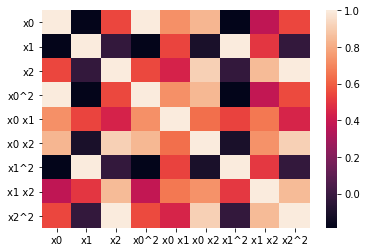

In [ ]:
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True) #interaction_only 改为真

X_poly = poly.fit_transform(X)
X_poly.shape

(162501, 6)

In [ ]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head() #因为interaction_only 为真，x0^2、x1^2 和x2^2 都消失了，因为这几列不和其他列交互

,x0,x1,x2,x0 x1,x0 x2,x1 x2
0,1502.0,2215.0,2153.0,3326930.0,3233806.0,4768895.0
1,1667.0,2072.0,2047.0,3454024.0,3412349.0,4241384.0
2,1611.0,1957.0,1906.0,3152727.0,3070566.0,3730042.0
3,1601.0,1939.0,1831.0,3104339.0,2931431.0,3550309.0
4,1643.0,1965.0,1879.0,3228495.0,3087197.0,3692235.0


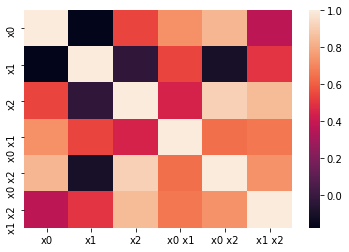

In [ ]:
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [ ]:
# 用新的多项式特征对KNN模型进行网格搜索，在流水线中进行。
# （1）先设置流水线参数：
pipe_params = {'poly_features__degree': [1, 2, 3], 'poly_features__interaction_only': [True, False], 'classify__n_neighbors': [3, 4, 5, 6]}

# (2) 然后实例化流水线：
from sklearn.pipeline import Pipeline

pipe = Pipeline([('poly_features', poly), ('classify', knn)])

# (3) 最后设置网格搜索，打印最佳准确率和学习到的参数：
grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7408140649873495 {'classify__n_neighbors': 5, 'poly_features__degree': 1, 'poly_features__interaction_only': True}


现在的准确率是72.12%，比之前不用多项式扩展的准确率有所提高。

## 4.5 针对文本的特征构建
在进一步研究之前，我们要保证对文本有了充分的理解。考虑一下商户点评服务：用户在平
台上撰写对餐厅和商家的评论，分享对自己体验的看法。这些评论都是文本格式的，包含可用于机器学习的大量有用信息，例如预测最应该去的餐厅。<br>
总体来说，在当今世界中，我们沟通方式的很大一部分还是基于书面文本，无论使用的是聊
天服务、社会媒体，还是电子邮件。通过建模，我们可以从中获得海量信息，例如用Twitter 数据进行情绪分析。<br>
这种工作叫作自然语言处理（NLP，natural language processing）。这个领域主要涉及计算机与人类的交流，特别是对计算机进行编程，以处理自然语言。

### 4.5.1 词袋法
接下来，我们可能会将文本数据称为语料库（corpus），尤其是指文本内容或文档的集合。<br>
将语料库转换为数值表示（也就是向量化）的常见方法是词袋（bag of words），其背后的基本思想是：通过单词的出现来描述文档，完全忽略单词在文档中的位置。在它最简单的形式中，用一个袋子表示文本，不考虑语法和词序，并将这个袋子视作一个集合，其中重复度高的单词更重要。词袋的3 个步骤是：
* 分词（tokenizing）：分词过程是用空白和标点将单词分开，将其变为词项。每个可能出现的词项都有一个整数ID。
* 计数（counting）：简单地计算文档中词项的出现次数。
* 归一化（normalizing）：将词项在大多数文档中的重要性按逆序排列。

下面了解另外几个向量化方法。

### 4.5.2 CountVectorizer
CountVectorizer 是将文本数据转换为其向量表示的最常用办法。和虚拟变量类似，
CountVectorizer 将文本列转换为矩阵，其中的列是词项，单元值是每个文档中每个词项的出现次数。这个矩阵叫文档-词矩阵（document-term matrix），因为每行代表一个文档（在本例中是一条推文），每列代表一个词（一个单词）。<br>
我们用一个新的数据集展示CountVectorizer 的工作原理。Twitter 情感分析数据集包括1 578 627 条分类后的推文，每行标记为1 或0：前者代表正面情绪，后者代表负面情绪。

In [ ]:
tweets = pd.read_csv('twitter_sentiment.csv', encoding='latin1') 
#指定了可选参数encoding，这是为了保证所有的特殊字符都可以正常处理

In [ ]:
tweets.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [ ]:
# 我们只关注Sentiment 和SentimentText 列，所以删除ItemID 列：
del tweets['ItemID']

In [ ]:
# 现在可以导入CountVectorizer，更好地理解这些文本：
from sklearn.feature_extraction.text import CountVectorizer

# 然后设置X 和y：
X = tweets['SentimentText']
y = tweets['Sentiment']

# CountVectorizer 和我们一直使用的自定义转换器非常类似，也有操作数据的fit_transform函数：
vect = CountVectorizer()
_ = vect.fit_transform(X)
print(_.shape)

(99989, 105849)


* CountVectorizer 的参数

我们会介绍以下几个参数：

In [ ]:
# stop_words：如果向其传入字符串english，那么CountVectorizer 会使用内置的英语停用词列表。你也可以自定义停用词列表。这些词会从词项中删除，不会表示为特征。
vect = CountVectorizer(stop_words='english') # 删除英语停用词（if、a、the, 等等）
_ = vect.fit_transform(X)
print(_.shape)

(99989, 105545)


可以看见，使用英语停用词后，特征列从105 849 下降到105 545。停用词的意义在于消除
特征的噪声，去掉在模型中意义不大的常用词。

In [ ]:
# min_df：它通过忽略在文档中出现频率低于阈值的词，减少特征的数量。使用min_df 的CountVectorizer 如下：

vect = CountVectorizer(min_df=.05) # 只保留至少在5%文档中出现的单词
# 减少特征数
_ = vect.fit_transform(X)
print(_.shape)

(99989, 31)


这极为有效地减少了特征数。

In [ ]:
# max_df：
vect = CountVectorizer(max_df=.8) # 只保留至多在80%文档中出现的单词
# “推断”停用词
_ = vect.fit_transform(X)
print(_.shape)

(99989, 105849)


这类似于试图理解文档中有哪些停用词。

In [ ]:
# ngram_range 参数：这个参数接收一个元组，表示n 值的范围（代表要提取的不同n-gram的数量）上下界。n-gram代表短语：
# 若n = 1，则其是一个词项；若n = 2，则其代表相邻的两个词项。可以预想到，这个方法会显著地增加特征集：

vect = CountVectorizer(ngram_range=(1, 5)) # 包括最多5 个单词的短语
_ = vect.fit_transform(X)
print(_.shape) # 特征数爆炸

(99989, 3219557)


冒出来了3 219 557 个特征。因为短语可能有其他含义，所以调整这个参数会对建模有帮助。

In [ ]:
# CountVectorizer 还可以设置分析器作为参数，以判断特征是单词还是短语。默认是单词：
vect = CountVectorizer(analyzer='word') # 默认分析器，划分为单词
_ = vect.fit_transform(X)
print(_.shape)

(99989, 105849)


我们甚至可以创建自定义分析器。理论上说，单词是由词根或词干构建而来的，所以可以据
此写一个自己的分析器。<br>

词干提取（stemming）是一种常见的自然语言处理方法，可以将词汇中的词干提取出来，也就是把单词转换为其词根，从而缩小词汇量。NLTK 是一个自然语言工具包，里面有几个可以处理文本数据的包，stemmer 就是其中之一。

下面解释一下stemmer 的工作原理。

In [ ]:
# (1) 首先导入stemmer，然后初始化：
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

In [ ]:
# (2) 看看stemmer 的效果：
stemmer.stem('interesting')

'interest'

In [ ]:
# (3) 单词interesting 变成了词根。现在可以用这个方法创建函数，将单词还原为词根：
# 将文本变成词根的函数
def word_tokenize(text, how='lemma'):
  words = text.split(' ') # 按词分词
  return [stemmer.stem(word) for word in words]

In [ ]:
# (4) 看看这个函数的效果：
word_tokenize("hello you are very interesting")

['hello', 'you', 'are', 'veri', 'interest']

In [ ]:
# (5) 将这个分词器传入分析器参数：
vect = CountVectorizer(analyzer=word_tokenize)
_ = vect.fit_transform(X)
print(_.shape) # 单词变小，特征少了

(99989, 154397)


这样处理后的特征减少了，而且符合直觉：我们的词汇量已经通过词干提取缩小了。

CountVectorizer 是一个非常有用的工具，不仅可以扩展特征，还可以将文本转换为数值
特征。我们再研究另一个常用的向量化器。

### 4.5.3 TF-IDF 向量化器
TF-IDF 向量化器由两部分组成：表示词频的TF 部分，以及表示逆文档频率的IDF 部分。
TF-IDF 是一个用于信息检索和聚类的词加权方法。
对于语料库中的文档，TF-IDF 会给出其中单词的权重，表示重要性。我们把每个部分拆开
来看。
* TF（term frequency，词频）：衡量词在文档中出现的频率。由于文档的长度不同，词在长文中的出现次数有可能比在短文中出现的次数多得多。因此，一般会对词频进行归一
化，用其除以文档长度或文档的总词数。
* IDF（inverse document frequency，逆文档频率）：衡量词的重要性。在计算词频时，我们认为所有的词都同等重要。但是某些词（如is、of 和that）有可能出现很多次，但这些词并不重要。因此，我们需要减少常见词的权重，加大稀有词的权重。

再次强调，TfidfVectorizer 和CountVectorizer 相同，都从词项构造了特征，但是
TfidfVectorizer 进一步将词项计数按照在语料库中出现的频率进行了归一化。我们看一个例子。

In [ ]:
# 首先是导入语句：
from sklearn.feature_extraction.text import TfidfVectorizer
# 还是之前的代码，用CountVectorizer 生成文档词矩阵：
vect = CountVectorizer()
_ = vect.fit_transform(X)
print(_.shape, _[0,:].mean())

#按此设置TfidfVectorizer：
vect = TfidfVectorizer()
_ = vect.fit_transform(X)
print(_.shape, _[0,:].mean()) # 行列数相同，内容不同

(99989, 105849) 6.613194267305311e-05
(99989, 105849) 2.1863060975751192e-05


可以看到，两个向量化器输出的行列数相同，但是里面的值不同。这是因为虽然TfidfVectorizer
和CountVectorizer 都可以把文本数据转换为定量数据，但是填充单元值的方法不同。

### 4.5.4 在机器学习流水线中使用文本
当然，向量化器的最终目标都是让机器学习流水线理解文本数据。因为CountVectorizer
和TfidfVectorizer 与本书中的其他转换器一样，所以要使用scikit-learn 流水线保证机器学习流水线的准确率和诚实度。本例要处理大量的列（数十万），所以我们使用在这种情况下更高效的分类器——朴素贝叶斯（naive Bayes）模型：

In [ ]:
from sklearn.naive_bayes import MultinomialNB # 特征数多时更快
# 在开始构建流水线之前，取响应列的空准确率（0 是负面情绪，1 是正面情绪）：
# 取空准确率
y.value_counts(normalize=True)

1    0.564632
0    0.435368
Name: Sentiment, dtype: float64

要让准确率超过56.5%。我们分两步创建流水线：
* 用CountVectorizer 将推文变成特征；
* 用朴素贝叶斯模型MultiNomialNB 进行正负面情绪的分类。

首先设置流水线的参数，然后实例化网格搜索：

In [ ]:
# 设置流水线参数
pipe_params = {'vect__ngram_range':[(1, 1), (1, 2)], 'vect__max_features':[1000,10000], 'vect__stop_words':[None, 'english']}
# 实例化流水线
pipe = Pipeline([('vect', CountVectorizer()), ('classify', MultinomialNB())])
# 实例化网格搜索
grid = GridSearchCV(pipe, pipe_params)
# 拟合网格搜索对象
grid.fit(X, y)
# 取结果
print(grid.best_score_, grid.best_params_)

0.7558931564507154 {'vect__max_features': 10000, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}


结果是75.6%，很不错！现在进一步调优，加入TfidfVectorizer。这次我们尝试新的做
法，比简单地利用TF-IDF 建立流水线高级一些。scikit-learn 有一个FeatureUnion 模块，可以水平（并排）排列特征。这样，在一个流水线中可以使用多种类型的文本特征构建器。

例如，可以构建一个featurizer 对象，在推文上使用TfidfVectorizer 和CountVectorizer，并且并排排列推文（行数相同，增加列数）：

In [ ]:
from sklearn.pipeline import FeatureUnion
# 单独的特征构建器对象
featurizer = FeatureUnion([('tfidf_vect', TfidfVectorizer()), ('count_vect', CountVectorizer())])

#然后可以看见数据的变化情况：
_ = featurizer.fit_transform(X)
print(_.shape) # 行数相同，但列数为2 倍

(99989, 211698)


可以看到，结合两个特征构建器后的数据集行数相同，但是因为TfidfVectorizer 和
CountVectorizer 并排，所以列数加倍。这样做可以让机器学习模型同时从两组数据中学习。

我们稍稍改变featurizer 对象的参数，看看效果：

In [ ]:
featurizer.set_params(tfidf_vect__max_features=100, count_vect__ngram_range=(1, 2), count_vect__max_features=300)
# TfidfVectorizer 只保留100 个单词，而CountVectorizer 保留300 个1～2 个单词的短语
_ = featurizer.fit_transform(X)
print(_.shape) # 行数相同，但列数为2 倍

(99989, 400)


In [ ]:
# 我们建立一个更完整的流水线，包括两个向量化器的特征结合：
pipe_params = {'featurizer__count_vect__ngram_range':[(1, 1), (1, 2)],
'featurizer__count_vect__max_features':[1000, 10000],
'featurizer__count_vect__stop_words':[None, 'english'],
'featurizer__tfidf_vect__ngram_range':[(1, 1), (1, 2)],
'featurizer__tfidf_vect__max_features':[1000, 10000],
'featurizer__tfidf_vect__stop_words':[None, 'english']}
pipe = Pipeline([('featurizer', featurizer), ('classify', MultinomialNB())])
grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)
print(grid.best_score_, grid.best_params_)

KeyboardInterrupt: ignored

这比单独使用CountVectorizer 好多了。值得注意的是，CountVectorizer 的最佳
ngram_range 是(1, 2)，而TfidfVectorizer 的是(1, 1)，代表单个词的出现没有2 个单词的短语那么重要。

至此，我们知道以下方法可以让流水线更加复杂：
* 对向量化器的几十个参数使用网格搜索；
* 在流水线上添加步骤，例如多项式特征构造。

但是对于本书而言这些操作很麻烦，在大多数笔记本电脑上要跑好几个小时。你
可以继续扩大流水线，尝试超过我们的得分记录。